Kaus2010_Rayleigh-Taylor_Instability
======

<table><tr><td><img src='./pic/kaus2010_RT_image0000.png'></td></tr></table>
Initial model setup with buoyancy perturbation.

This notebook models the Rayleigh-Taylor instability outlined in van Kaus *et al.* (2010) for the FSSA algorithm test. 

The system of equations is given by

$$
    \nabla \cdot \left( \eta \nabla \dot\varepsilon \right) - \nabla p = -\rho g \mathbf{\hat z}
$$

$$
    \nabla \cdot \mathbf{v} = 0
$$

**Keywords:** particle swarms, Stokes system, advective diffusive systems

**References**

- Kaus, B.J.P., et al., A stabilization algorithm for geodynamic numerical simulations with a free surface. Phys.
Earth Planet. In. (2010), doi:10.1016/j.pepi.2010.04.007

In [1]:
import underworld as uw
from underworld import function as fn
import underworld.visualisation as vis

from underworld.scaling import units as u
from underworld.scaling import dimensionalise 
from underworld.scaling import non_dimensionalise as nd

import math
import numpy as np
import os

In [2]:
# build reference units
KL_meters   = 500 * u.kilometer
K_viscosity = 1e20  * u.pascal * u.second
K_density   = 3200 * u.kilogram / u.meter**3

# compute dependent scaling units 
#KT_seconds = 5*u.kiloyear
#KM_kilograms = KT_seconds * KL_meters * K_viscosity
KM_kilograms = K_density * KL_meters**3
KT_seconds   = KM_kilograms / ( KL_meters * K_viscosity )
K_substance  = 1. * u.mole
#Kt_degrees   = 1. * u.kelvin

scaling_coefficients = uw.scaling.get_coefficients()
scaling_coefficients["[length]"]      = KL_meters.to_base_units()
#scaling_coefficients["[temperature]"] = Kt_degrees.to_base_units()
scaling_coefficients["[time]"]        = KT_seconds.to_base_units()
scaling_coefficients["[mass]"]        = KM_kilograms.to_base_units()

gravity = nd( 9.81 * u.meter / u.second**2)

ymaxCoord = nd(0.* u.kilometer)
yminCoord = nd(-500* u.kilometer)
xmaxCoord = nd(250* u.kilometer)
xminCoord = nd(-250* u.kilometer)

In [3]:
useFSSA = True
useFreeSlip = False

DT = nd(5e3*u.year) #DT = nd(5e4*u.year)
theta = 1.0

model_end_step   = 80
res              = 64
stokes_inner_tol = 1e-6
stokes_outer_tol = 1e-5

# output
if useFreeSlip:
    output_path = "Kaus2010_RTI_FreeSlip_5ka/" #"Kaus2010_RTI_FreeSlip_50ka/"
else:
    if useFSSA:
         output_path ="Kaus2010_RTIwithFSSA_theta"+str(theta).zfill(2) +"/" 
    else:
         output_path ="Kaus2010_RTInoFSSA/"

# search and build, if required, an output path
if uw.mpi.rank==0:
    try:
        if not os.path.exists("./"+output_path+"/"):
            os.makedirs("./"+output_path+'/')
    except:
        raise

In [4]:
# build mesh and mesh variables
resolution       = (64,64)
mesh = uw.mesh.FeMesh_Cartesian( elementType = 'Q1/dQ0', 
                                 elementRes  = resolution, 
                                 minCoord    = [xminCoord,yminCoord], 
                                 maxCoord    = [xmaxCoord,ymaxCoord],
                                 periodic    = [False, False] )

velocityField   = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=mesh.dim )
pressureField   = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.

In [5]:
# Create a swarm.
swarm = uw.swarm.Swarm( mesh=mesh,particleEscape=True)
swarm2 = uw.swarm.Swarm( mesh=mesh, particleEscape=True)

# Create a data variable. It will be used to store the material index of each particle.
materialIndex = swarm.add_variable( dataType="int", count=1 )

# Create a layout object, populate the swarm with particles.
swarmLayout = uw.swarm.layouts.PerCellSpaceFillerLayout( swarm=swarm, particlesPerCell=20 )
swarm.populate_using_layout( layout=swarmLayout )
pop_control = uw.swarm.PopulationControl(swarm,aggressive=True,splitThreshold=0.15, maxDeletions=2,maxSplits=10,
                                                particlesPerCell=20)

In [6]:
# define these for convience. 
denseIndex = 0
lightIndex = 1

# material perturbation from van Keken et al. 1997
wavelength = nd(xmaxCoord*2)
amplitude  = nd(5*u.kilometer)
offset     = nd(-100.*u.kilometer)
k = 2. * math.pi / wavelength

# Create function to return particle's coordinate
coord = fn.coord()

# Define the material perturbation, a function of the x coordinate (accessed by `coord[0]`).
perturbationFn = offset + amplitude*fn.math.cos( k*coord[0] )

# Setup the conditions list. 
# If z is less than the perturbation, set to lightIndex.
conditions = [ ( perturbationFn > coord[1] , lightIndex ),
               (                      True , denseIndex ) ]

# The swarm is passed as an argument to the evaluation, providing evaluation on each particle.
# Results are written to the materialIndex swarm variable.
materialIndex.data[:] = fn.branching.conditional( conditions ).evaluate(swarm)


interfacePoints = np.zeros((resolution[0]*5,2))
interfacePoints[:,0] = np.linspace(xminCoord, xmaxCoord, resolution[0]*5)
for index in range(len(interfacePoints[:,0])):
    interfacePoints[index,1] = offset + amplitude*math.cos(k*interfacePoints[index,0])
swarm2.add_particles_with_coordinates(interfacePoints)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18


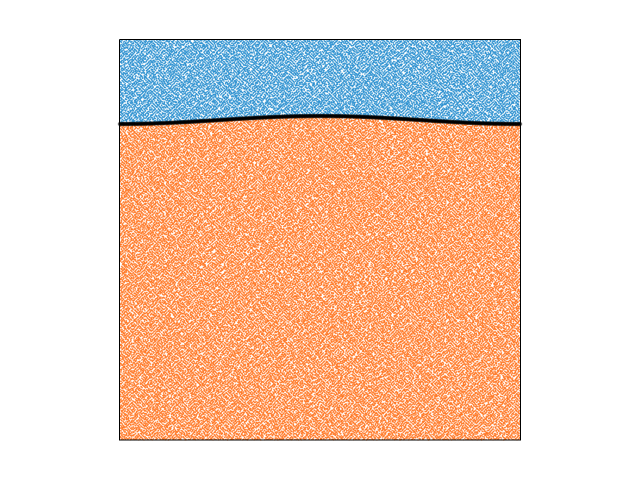

'Kaus2010_RTIwithFSSA_theta1.0/image_0.png'

In [7]:
fig1 = vis.Figure() #title="Material", figsize=(400,400), quality=2, rulers=True)
fig1.Points(swarm2,pointSize=5, colourBar=False)
fig1.Points(swarm, materialIndex, fn_size=2.,discret=True,colourBar = False) 
fig1.VectorArrows(mesh, velocityField) 
fig1.show()
fig1.save_image(output_path+"image_0")

In [8]:
light_density = nd(3200 * u.kilogram / u.meter**3)
dense_density = nd(3300 * u.kilogram / u.meter**3)
light_viscosity = nd(1e20 * u.pascal * u.second)
dense_viscosity = nd(1e21 * u.pascal * u.second)


# Set a density of '0.' for light material, '1.' for dense material.
densityMap   = { lightIndex:light_density, denseIndex:dense_density }
densityFn    = fn.branching.map( fn_key = materialIndex, mapping = densityMap )

# Set a viscosity value of '1.' for both materials.
viscosityMap = { lightIndex:light_viscosity, denseIndex:dense_viscosity }
fn_viscosity  = fn.branching.map( fn_key = materialIndex, mapping = viscosityMap )

# Define a vertical unit vector using a python tuple.
z_hat = ( 0.0, -1.0 )

# Create buoyancy force vector
buoyancyFn = densityFn*z_hat*gravity

In [9]:
# Construct node sets using the mesh specialSets
iWalls = mesh.specialSets["Left_VertexSet"]   + mesh.specialSets["Right_VertexSet"]
jWalls = mesh.specialSets["Bottom_VertexSet"] + mesh.specialSets["Top_VertexSet"]
botWalls = mesh.specialSets["Bottom_VertexSet"]
allWalls = iWalls + jWalls

if useFreeSlip:
    # no slip sides, free slip bottom, free lip top
    stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                             indexSetsPerDof = (iWalls+botWalls,jWalls) )
else:
    # no slip sides, free slip bottom, open top
    stokesBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                             indexSetsPerDof = (iWalls+botWalls,botWalls) )

In [10]:
# define an update function
fn_fssa = None
proj_buoy = True # for initial debug
if useFSSA == True:
    print("use FSSA")
    fn_fssa = buoyancyFn * DT *  theta
    
if proj_buoy == True:
    pbuoy = mesh.add_variable(nodeDofCount=mesh.dim)
    projB = uw.utils.MeshVariable_Projection(pbuoy, fn=buoyancyFn)

stokes = uw.systems.Stokes( velocityField = velocityField, 
                            pressureField = pressureField,
                            conditions    = stokesBC,
                            fn_viscosity  = fn_viscosity, 
                            fn_bodyforce  = buoyancyFn,
                            _fn_fssa      = fn_fssa )

solver = uw.systems.Solver( stokes )

# Optional solver settings
if(uw.mpi.size==1):
    solver.set_inner_method("lu")
solver.set_inner_rtol(stokes_inner_tol) 
solver.set_outer_rtol(stokes_outer_tol) 

# Create a system to advect the swarm
advector = uw.systems.SwarmAdvector( swarm=swarm, velocityField=velocityField, order=2 )
advector2 = uw.systems.SwarmAdvector( swarm=swarm2, velocityField=velocityField, order=2 )

use FSSA



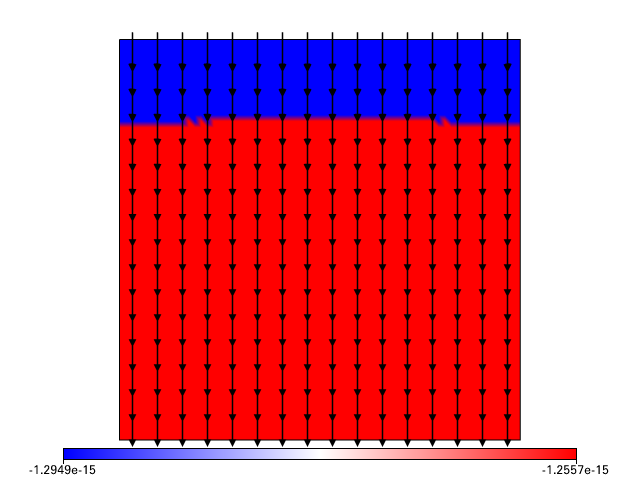

In [11]:
projB.solve()
fig = vis.Figure() #title="Material", figsize=(400,400), quality=2, rulers=True)
# fig.Sur(swarm, materialIndex, fn_size=2.,discret=True,colourBar = False) 
fig.append( vis.objects.Surface(mesh, buoyancyFn[1], colours="blue white red") )

fig.VectorArrows(mesh, buoyancyFn) 
fig.show()
# fig1.save_image(output_path+"image_0")

In [12]:
# Initialise time and timestep.
time = 0.
step = 0

# parameters for output
outputEvery  = 1
timeVal     = []
vrmsVal     = []

# Save mesh and retain file handle for future xdmf creation
meshFileHandle = mesh.save(output_path+"Mesh.h5")


def update():   
    #dt = advector.get_max_dt() # retrieve the maximum possible timestep from the advection system.
    dt = DT
    advector.integrate(dt, update_owners=False)  #?update_owners=True
    advector2.integrate(dt,update_owners=False)
        
    #pop_control.repopulate()
    swarm.update_particle_owners()
    swarm2.update_particle_owners()
    pop_control.repopulate()
    
    return time+dt, step+1, dt

In [13]:
while step < model_end_step:
    # Get solution
    solver.solve()
    
    # Calculate the RMS velocity.
    vrms = stokes.velocity_rms()

    # Record values into arrays
    if(uw.mpi.rank==0):
        vrmsVal.append(dimensionalise(vrms,u.meter/u.year).m)
        timeVal.append(dimensionalise(time, u.kiloyear).m)
     
    time, step, dt = update()
    if(uw.mpi.rank==0):
        string = "{:4d}, {:.3e},{:.3e},{:.3e}".format(step,dimensionalise(dt, u.kiloyear),dimensionalise(time, u.kiloyear),dimensionalise(vrms,u.meter/u.year)) 
        print(string)
                                                   
    # Output to disk
    if step%outputEvery == 0:
        #if(uw.mpi.rank==0):
        #    print('step = {0:6d}; time = {1:.3e}; v_rms = {2:.3e}'.format(step,time,vrms))

        filename = output_path+"/velocityField."+str(step).zfill(4)
        vFH      = velocityField.save(filename+".h5")
        velocityField.xdmf( filename, vFH, "velocity", meshFileHandle, "Mesh", time )
        
        filename = output_path+"/pressureField."+str(step).zfill(4)
        pFH      = pressureField.save(filename+".h5")
        pressureField.xdmf(filename, pFH, "pressure", meshFileHandle, "Mesh", time )
        
        swarm2.save(output_path+"surfaceSwarm"+ str(step).zfill(4)+".h5")
        
        outputFilename = output_path+"image"+str(step).zfill(4)
        fig1.save_image(outputFilename)

    # We are finished with current timestep, update.
    #updateMesh()

fname_save = output_path+"data_time_vrms.txt"
np.savetxt(fname_save, np.column_stack((timeVal ,vrmsVal)),fmt='%1.3e %1.3e')

   1, 5.000e+00 kiloyear,5.000e+00 kiloyear,7.668e-03 meter / year
   2, 5.000e+00 kiloyear,1.000e+01 kiloyear,7.889e-03 meter / year
   3, 5.000e+00 kiloyear,1.500e+01 kiloyear,8.067e-03 meter / year
   4, 5.000e+00 kiloyear,2.000e+01 kiloyear,8.202e-03 meter / year
   5, 5.000e+00 kiloyear,2.500e+01 kiloyear,8.373e-03 meter / year
   6, 5.000e+00 kiloyear,3.000e+01 kiloyear,8.585e-03 meter / year
   7, 5.000e+00 kiloyear,3.500e+01 kiloyear,8.698e-03 meter / year
   8, 5.000e+00 kiloyear,4.000e+01 kiloyear,9.073e-03 meter / year
   9, 5.000e+00 kiloyear,4.500e+01 kiloyear,9.359e-03 meter / year
  10, 5.000e+00 kiloyear,5.000e+01 kiloyear,9.556e-03 meter / year
  11, 5.000e+00 kiloyear,5.500e+01 kiloyear,9.653e-03 meter / year
  12, 5.000e+00 kiloyear,6.000e+01 kiloyear,9.885e-03 meter / year
  13, 5.000e+00 kiloyear,6.500e+01 kiloyear,1.021e-02 meter / year
  14, 5.000e+00 kiloyear,7.000e+01 kiloyear,1.031e-02 meter / year
  15, 5.000e+00 kiloyear,7.500e+01 kiloyear,1.036e-02 meter / 